In [ ]:
### Instalation

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:

    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install trl==0.23.1 --no-deps
import torch; torch._dynamo.config.recompile_limit = 64;

In [ ]:
%%capture
!pip install --no-deps --upgrade timm # Only for Gemma 3N

In [ ]:
# Imports

In [ ]:
from unsloth import FastModel
import unsloth
import torch

# Now, import other libraries
from google.colab import drive
from google.colab import userdata
from huggingface_hub import login
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from functools import partial
from datetime import datetime

from unsloth import FastVisionModel
from transformers import AutoProcessor

from tqdm import tqdm
from peft import PeftModel
from unsloth.chat_templates import get_chat_template
from datetime import datetime

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

hf_token = userdata.get('HF_TOKEN')
login(token=hf_token)

In [ ]:


ruta = '/content/drive/MyDrive/Colab Notebooks/DatasetV1/datasetV1.csv'
df = pd.read_csv(ruta, encoding='utf-8')

print(df.head())

                                                 url  \
0  http://bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3...   
1  http://bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bj...   
2  http://bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgq...   
3              http://01anjali2001.github.io/netflix   
4  http://bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj...   

                                        html_content  \
0  0001_bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3td...   
1  0002_bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpd...   
2  0003_bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtu...   
3      0004_01anjali2001.github.io_netflix/page.html   
4  0005_bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj5a...   

                                          screenshot  label  
0  0001_bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3td...      1  
1  0002_bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpd...      1  
2  0003_bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtu...      1  
3  0004_01anjali2001.github.io_netflix/screenshot...      1  
4  0005_bafybeid

In [ ]:
df.dropna(inplace=True)

print(df.info())

print(df.describe())

print(df.isnull().sum())

if 'label' in df.columns:
    print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           1000 non-null   object
 1   html_content  1000 non-null   object
 2   screenshot    1000 non-null   object
 3   label         1000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None
           label
count  1000.0000
mean      0.8000
std       0.4002
min       0.0000
25%       1.0000
50%       1.0000
75%       1.0000
max       1.0000
url             0
html_content    0
screenshot      0
label           0
dtype: int64
label
1    800
0    200
Name: count, dtype: int64


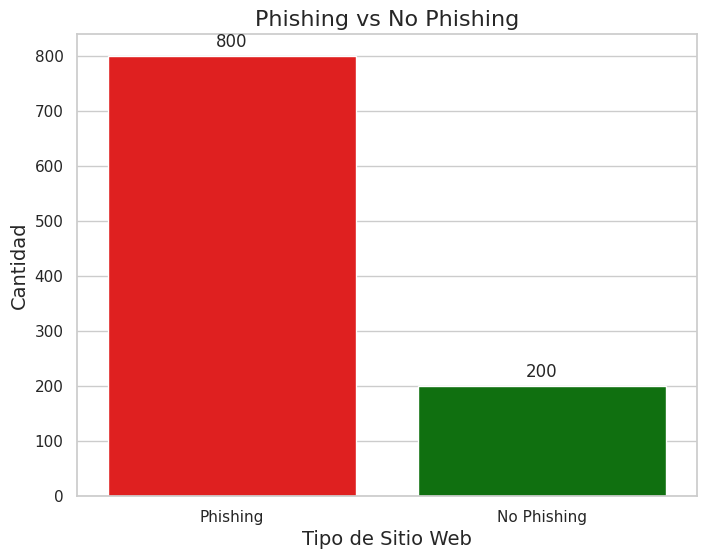

In [ ]:
label_map = {0: 'No Phishing', 1: 'Phishing'}

df['label_name'] = df['label'].map(label_map)

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label_name', data=df, hue='label_name', palette={'No Phishing': 'green', 'Phishing': 'red'}, legend=False)

plt.title('Phishing vs No Phishing', fontsize=16)
plt.xlabel('Tipo de Sitio Web', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12)

plt.show()

In [ ]:
def _configurar_modelo_unsloth(modelo_id: str, ruta_finetune: str = None):
    print(f"⚡ Configurando y cargando modelo Unsloth para {modelo_id}...")

    torch.cuda.empty_cache()

    model, processor = FastVisionModel.from_pretrained(
        "unsloth/gemma-3n-E4B-it",
        load_in_4bit=True,
        max_seq_length=8192,
        dtype=None,
        use_gradient_checkpointing="unsloth",
    )

    model.load_adapter(ruta_finetune)
    model.enable_adapters()  #

    FastVisionModel.for_inference(model)


    print(f"✅ Modelo '{modelo_id}' cargado correctamente con Unsloth (VLM mode).")
    return model, processor



In [ ]:
def _cargar_datos_fila(row: pd.Series, ruta_base: str):

    html_path = os.path.join(ruta_base, row['html_content'])
    screenshot_path = os.path.join(ruta_base, row['screenshot'])

    with open(html_path, 'r', encoding='utf-8') as file:
        html_content = file.read()

    screenshot = Image.open(screenshot_path).convert('RGB')
    if screenshot is None:
        raise ValueError(f"No se pudo cargar la imagen: {screenshot_path}")
    screenshot = screenshot.resize((512, 512))

    return html_content, screenshot

In [ ]:
def prompt_option1_all(html_content: str, screenshot: Image.Image, url: str):
    screenshot = screenshot.resize((512, 512))

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    """
                    Act as a professional cybersecurity specialist reviewing websites to determinate if they are fishing or not. You will receive a URL, the HTML of the website and a screenshot.
                    Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name
                    """
                    f"URL: {url}\n"
                    f"HTML extract: {html_content[:5000]}"
                )},
                {"type": "image", "image": screenshot}
            ]
        }
    ]

    return messages

In [ ]:
def prompt_option2_all(html_content: str, screenshot: Image.Image, url: str):
    screenshot = screenshot.resize((512, 512))

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    """
                    Act as a professional cybersecurity specialist reviewing websites to determinate if they are fishing or not. You will receive a URL, the HTML of the website and a screenshot.
                    Consider:
                      1.Identification of the main brand the page is attempting to represent
                      2.Suspicious elements (credential fields, urgent calls to action)
                      3.Consistency between the identified brand and the displayed domain
                      4.Typical visual characteristics of phishing (low-quality logos, typographical errors)
                    Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name
                    """
                    f"URL: {url}\n"
                    f"HTML extract: {html_content[:5000]}"
                )},
                {"type": "image", "image": screenshot}
            ]
        }
    ]

    return messages

In [ ]:
def prompt_option3_all(html_content: str, screenshot: Image.Image, url: str):
    screenshot = screenshot.resize((512, 512))

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    """
              [Context] You are a professional cybersecurity specialist reviewing websites to determinate if they are fishing or not. You will receive a URL, the HTML of the website and a screenshot.
              Follow this process:

                  Visual Analysis:
                      Identify the main visual elements (logos, colors, structure)
                      Look for inconsistencies in the design or low-quality elements
                      Detect any fields for entering sensitive data

                  Content Analysis:
                      Extract the main text and analyze its tone and content
                      Look for urgent language or threats
                      Verify consistency with the supposed brand

                  URL Analysis:
                      Examine the domain and compare it with the identified brand
                      Look for suspicious characters or typosquatting techniques

                  Conclusion:
                      Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name

              """
                    f"URL: {url}\n"
                    f"HTML extract: {html_content[:5000]}"
                )},
                {"type": "image", "image": screenshot}
            ]
        }
    ]

    return messages

In [ ]:

def _generar_respuesta_gemma3(model, tokenizer, messages, max_new_tokens = 256):
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    )

    # Mover el input a la GPU si es necesario
    inputs = inputs.to("cuda")

    # Generar la respuesta sin un streamer
    # outputs = model.generate(
    #     **inputs,
    #     max_new_tokens=max_new_tokens,
    #     temperature=1.0,
    #     top_p=0.95,
    #     top_k=64,
    #     do_sample=True,
    #     pad_token_id=tokenizer.eos_token_id
    # )

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )

    print(outputs)
    generated_text = tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True)

    return generated_text


In [ ]:
def _procesar_fila_gemma3(row: pd.Series, model, tokenizer,
                         ruta_base: str, output_filepath: str, metodo_prompt_a_usar):
    """Procesa una fila con el modelo Gemma 3"""
    url = row.get('url', 'URL desconocida')
    label = row.get('label', 'Label desconocido')
    label_text = "PHISHING (true)" if label == 1 else "SAFE (false)"

    try:
        html_content, screenshot = _cargar_datos_fila(row, ruta_base)

        messages = metodo_prompt_a_usar(html_content, screenshot, url)

        generated_text = _generar_respuesta_gemma3(model, tokenizer, messages)
        format_text = _procesar_generated_text_gemma3(generated_text)

        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"--- Salida para URL: {url} {label_text} ({timestamp}) ---")
        print(format_text[:500] + "..." if len(format_text) > 500 else format_text)
        print(f"--- Fin Salida ---")

        try:
            with open(output_filepath, 'a', encoding='utf-8') as f:
                f.write(f"URL: {url}\n")
                f.write(f"Resultado esperado: {label_text}\n")
                f.write(f"Salida: {format_text}\n")
                f.write("-" * 80 + "\n\n")
        except IOError as e:
            print(f"❌ Error escribiendo en archivo: {e}")

        return format_text

    except Exception as e:
        print(f"❌ Error procesando {url}: {type(e).__name__} - {e}")
        return f"Error: {str(e)}"

In [ ]:
def _procesar_generated_text_gemma3(generated_text: str):
    if "assistant" in generated_text.lower():
        parts = generated_text.split("assistant")
        if len(parts) > 1:
            return parts[-1].strip()

    return generated_text.strip()

In [ ]:
def clasificador_gemma3(modelo_id: str, df: pd.DataFrame, ruta_base: str,
                       output_filepath: str, metodo_prompt_a_usar, ruta_finetune):
    """Función principal para clasificar con Gemma 3"""
    model = None
    tokenizer = None

    try:
        model, tokenizer = _configurar_modelo_unsloth(modelo_id, ruta_finetune)

        def procesar_fila_con_contexto(row):
            return _procesar_fila_gemma3(
                row,
                model=model,
                tokenizer=tokenizer,
                ruta_base=ruta_base,
                output_filepath=output_filepath,
                metodo_prompt_a_usar=metodo_prompt_a_usar
            )

        print(f"🚀 Procesando {len(df)} filas con Gemma 3...")
        predicciones = df.apply(procesar_fila_con_contexto, axis=1)
        df['prediccion'] = predicciones
        print("✅ Procesamiento completado.")

        return df

    except Exception as e:
        print(f"❌ Error crítico: {type(e).__name__} - {e}")
        return df

    finally:
        # 4. Liberar memoria
        if model is not None:
            print("🧹 Liberando modelo Gemma 3...")
            try:
                model.cpu()
                del model
            except:
                pass
            torch.cuda.empty_cache()
            print("✅ Memoria liberada.")

In [ ]:
#EJECUCION

In [ ]:

modelo_seleccionado = "unsloth/gemma-3n-E4B-it"

ruta_base_archivos = '/content/drive/MyDrive/Colab Notebooks/DatasetV1'
ruta_base_archivos = os.path.join(ruta_base_archivos, '')
ruta_csv = '/content/drive/MyDrive/Colab Notebooks/DatasetV1/datasetV1.csv'
ruta_directorio_salida = '/content/drive/MyDrive/Colab Notebooks'
df_datos = pd.read_csv(ruta_csv, encoding='utf-8')

ruta_finetune='/content/drive/MyDrive/Colab Notebooks/gemma3n-it-phishing-lora'


metodos_prompt_gemma3 = [
    prompt_option1_all,
    prompt_option2_all,
    prompt_option3_all
]

print(f"\n===== Procesando Modelo: {modelo_seleccionado} =====")
nombre_base_archivo = modelo_seleccionado.split('/')[-1]

for i, metodo_prompt in enumerate(metodos_prompt_gemma3):
    nombre_metodo = metodo_prompt.__name__

    nombre_archivo_salida = f"{nombre_base_archivo}_{nombre_metodo}_resultados.txt"
    ruta_archivo_salida_final = os.path.join(ruta_directorio_salida, nombre_archivo_salida)

    print(f"  --- Ejecutando con método: {nombre_metodo} ---")
    print(f"  Guardando resultados en: {ruta_archivo_salida_final}")


    df_resultado = clasificador_gemma3(
        modelo_id=modelo_seleccionado,
        df=df_datos,
        ruta_base=ruta_base_archivos,
        output_filepath=ruta_archivo_salida_final,
        metodo_prompt_a_usar=metodo_prompt,
        ruta_finetune=ruta_finetune
    )

    print(f"✅ Resultados guardados en {ruta_archivo_salida_final}")
    print("-" * 50)


===== Procesando Modelo: unsloth/gemma-3n-E4B-it =====
  --- Ejecutando con método: prompt_option1_all ---
  Guardando resultados en: /content/drive/MyDrive/Colab Notebooks/gemma-3n-E4B-it_prompt_option1_all_resultados.txt
⚡ Configurando y cargando modelo Unsloth para unsloth/gemma-3n-E4B-it...
==((====))==  Unsloth 2025.10.12: Fast Gemma3N patching. Transformers: 4.55.4.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.72G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
         236813,    107,    160,   3407,  58262,    107,    160, 236820, 236747,
           1012,    718,   5742, 236772,  26252,   2854, 236772,   2925, 236772,
            898,    905,    210,    107,    156,    954,   2569, 236813,    107,
            152,    235,    107,    148,    235,    107,    144,    235,    108,
            144, 236820,   3231,   4474,    718,  18770, 236761,   2092,   8503,
           3231, 236813,    107,    140,    108,    229,    228,    108, 255999,
         262145, 262145, 262145, 262145, 262145, 262145, 262145, 262145, 262145,
         262145, 262145, 262145, 262145, 262145, 262145, 262145, 262145, 262145,
         262145, 262145, 262145, 262145, 262145, 262145, 262145, 262145, 262145,
         262145, 262145, 262145, 262145, 262145, 262145, 262145, 262145, 262145,
         262145, 262145, 262145, 262145, 262145, 262145, 262145, 262145, 262145,
         262145, 262145, 262145, 262145, 262145,

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
         236820,   3024,   4474,    718,  11920, 236761,   5479,    905,    231,
            107,    148,    224,    107,    152, 236820,   2569, 236813,  27832,
            954,   2569, 236813,    107,    152, 236820,   2569,   3117,    718,
           7682, 236772,   3001, 236787,   2604,  17502,  10150,    799,    954,
           2569, 236813,    107,    148,    235,    107,    144,    954,   4145,
         236813,    107,    144, 236820,   1928,   1012,    718,   2566,    905,
            107,    144,    235,    107,    144, 236820,   1928,   1012,    718,
          18076,    905,    107,    148,    220,  85784,  13154, 236764,   6115,
           3831,    532,    919,    231,    108,    148,    220,  16501,  14027,
         236761,  57321,  36448, 236761,    231,    108,    148,    220,  44096,
            531,   4526, 236881,  10152,    822,   4553,    531,   2619,    653,
          23475,    822,  15419, 236761,    231,

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
           2425,    718, 236812, 236771, 236775,  62925,    670,   1693,    969,
            718,   2865, 236775,   1722,    718,   1005, 236775,  19738,    718,
         102941, 236775,   3117,  16248,    183,    107,    181,    107,    173,
         236820,   2004,   1012,    718,   3250,   4001,   2491,    573,    718,
           1916,   1528,    679,  39144,  13651,    905,  12903,    954,   2491,
         236813,    107,    183,    107, 236820,   2004,   1012,    718,   2427,
           4001,   2427,   1463,    718,  73790, 236775,   1846,    718,  73790,
         236775,   3149,    718,  15979, 236775,   2425,    718, 236812, 236771,
         236775,  62925,    670,   1693,    969,    718,   2865, 236775,   1722,
            718,   8707, 236775,   3117,  16248,    183,    107,    181,    107,
            179,    107,    176,    107, 236820, 236758,   1012,    718,    845,
          36824,   4001,   2427,   1722,    718,